In [149]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from scipy.optimize import curve_fit

Now inlcluding the polynomial coefficients that were in Thomas' GeN-Foam model so I can see how they change over our temperature range. I am also defining the temperature range as well as a couple of functions to do this. 

In [150]:
rhoCoefs_old = [2.98268929e+02,  -1.31815938e+00, 2.81092249e-03,  -3.26269179e-06,
            2.16673749e-09,  -8.20663892e-13, 1.64676554e-16,  -1.35696602e-20]

# specific heat coefficients (J/(kg*K))
cpCoefs_old = [1.266445630e+04, 1.17094171e+01, -2.98179826e-02, 3.81902598e-05,
            -2.54178633e-08, 9.28566400e-12, -1.77480852e-15, 1.39051574e-19]

muCoefs_old = [8.9385e-6,0,0,0,0,0,0,0]

kappaCoefs_old = [0.01238494, 0.00057219, 0, 0, 0, 0, 0, 0]

# >>>>>> inlet/outlet conditions >>>>>>
inlet_pressure = 7.2e6 # MPa
outlet_pressure = 7e6 # MPa

inlet_temperature = 300 # Kelvin
outlet_temperature = 7300 # Kelvin
# <<<<<< inlet/outlet conditions <<<<<<
Tstart = 30
Tend = 4000
Pstart = 7.4e6
Pend = 6.9e6

dpoints = 4000 # lenght of the linspace array
temperature = np.linspace(30,outlet_temperature,dpoints)
pressure = np.linspace(7.4e6,6.9e6,dpoints)

def polynomial8(t,c): # t is temperature and c is the coefficiareents
    f = c[0] + c[1]*t + c[2]*t**2 + c[3]*t**3 + c[4]*t**4 + c[5]*t**5 + c[6]*t**6 + c[7]*t**7
    return f

def plot(t,c,n,title): # t is temp, c is coefs, n is figure #, title is title name
    mx = max(polynomial8(t,c))
    plt.figure(n)
    plt.plot(t,polynomial8(t,c))
    plt.title(title)
    plt.ylim(0,mx+0.15*mx)


### Plotting Old Material Polynomials

1. Density (kg/m^3)

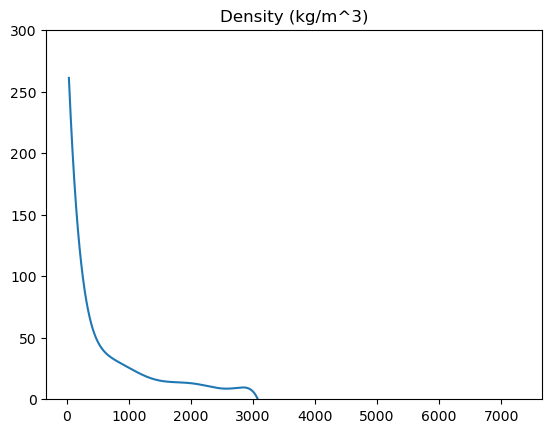

In [151]:
plot(temperature,rhoCoefs_old,1,'Density (kg/m^3)')

2. Specific Heat (J/(kg*K))

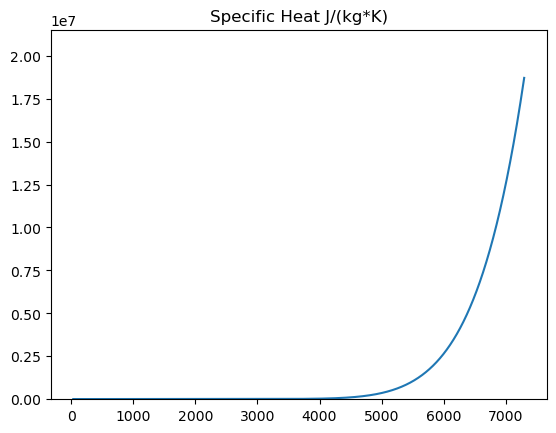

In [152]:
plot(temperature,cpCoefs_old,2,'Specific Heat J/(kg*K)')

3. Viscosity (Pa * s)

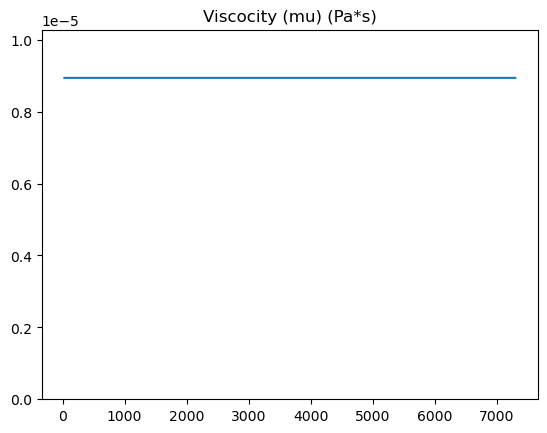

In [153]:
plot(temperature,muCoefs_old,3,'Viscocity (mu) (Pa*s)')

4. Thermal Conductivity (W/(m*K))

In [154]:
plot(temperature,kappaCoefs_old,4,'Thermal Conductivity (W/(m*K))')

### Now finding values from NIST

Then, finding NIST predicted density, specific heat, viscosity, and thermal conductivity 

In [155]:
fluid = 'H2'

nist_densities = []  # Empty list to store the calculated densities
nist_specificHeats = []
nist_viscosities = [] 
nist_conductivities = []

for i in range(dpoints):
    density = PropsSI('Dmass', 'T', temperature[i], 'P', pressure[i], fluid)
    nist_densities.append(density)

    specificHeat = PropsSI('Cp0mass','T',temperature[i],'P',pressure[i], fluid)
    nist_specificHeats.append(specificHeat)

    viscosity = PropsSI('viscosity','T',temperature[i],'P',pressure[i], fluid)
    nist_viscosities.append(viscosity)

    conductivity = PropsSI('conductivity','T',temperature[i],'P',pressure[i], fluid)
    nist_conductivities.append(conductivity)
    



### Comparing NIST values to that of old coefficients

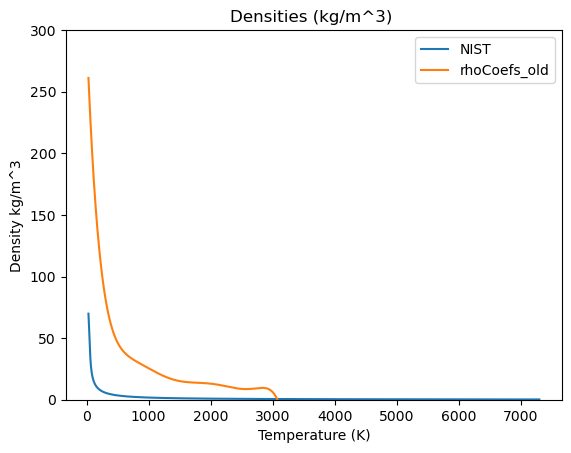

In [156]:
plt.figure(1)
plt.plot(temperature,nist_densities,label='NIST')
plt.plot(temperature,polynomial8(temperature,rhoCoefs_old),label='rhoCoefs_old')
plt.title('Densities (kg/m^3) ')
plt.xlabel('Temperature (K)')
plt.ylabel('Density kg/m^3')
plt.ylim(0,300)
plt.legend(loc='best')


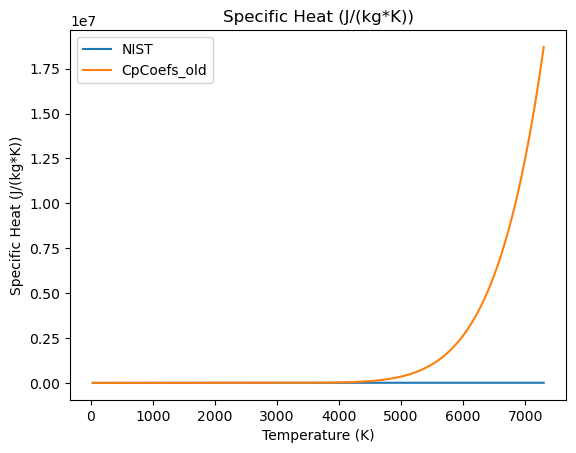

In [157]:
plt.figure(2) # plotting specific heat
plt.plot(temperature,nist_specificHeats,label='NIST')
plt.plot(temperature,polynomial8(temperature,cpCoefs_old),label='CpCoefs_old')
plt.title('Specific Heat (J/(kg*K))')
plt.xlabel('Temperature (K)')
plt.ylabel('Specific Heat (J/(kg*K))')
#plt.ylim(0,300)
plt.legend(loc='best')

In [158]:
plt.figure(3) # plotting viscosity
plt.plot(temperature,nist_viscosities,label='NIST')
plt.plot(temperature,polynomial8(temperature,muCoefs_old),label='MuCoefs_old')
plt.title('Viscosity (Pa*s)')
plt.xlabel('Temperature (K)')
plt.ylabel('Viscosity (Pa*s)')
#plt.ylim(0,300)
plt.legend(loc='best')

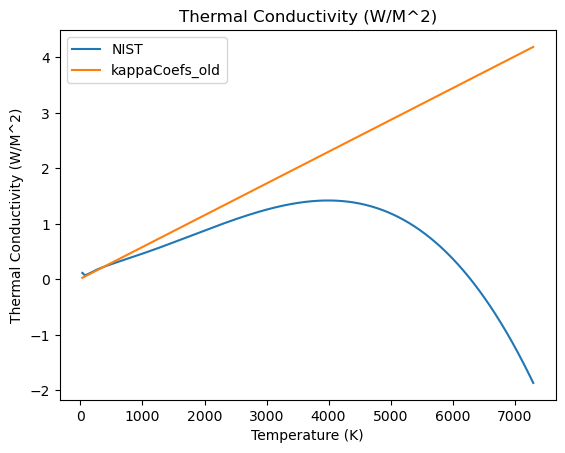

In [159]:
plt.figure(4) # plotting thermal conductivity
plt.plot(temperature,nist_conductivities,label='NIST')
plt.plot(temperature,polynomial8(temperature,kappaCoefs_old),label='kappaCoefs_old')
plt.title('Thermal Conductivity (W/M^2)')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/M^2)')
#plt.ylim(0,300)
plt.legend(loc='best')

### Finding Coefficients using a line of best fit on NIST data:


In [160]:
# making a new polynomial8 function for the curve_fit function
def polynomial8cf(t,c0,c1,c2,c3,c4,c5,c6,c7): # t is temperature and c is the coefficiareents
    f = c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5 + c6*t**6 + c7*t**7
    return f

def line(t,c0,c1):
    f = c0 + c1*t
    return f

# the below lines are to show the density of H at inlet & outlet conditions. This can be used to make the linear fit
tDiffInlet = np.abs(temperature - inlet_temperature)
tDiffOutlet = np.abs(temperature - outlet_temperature) # you have to take absolute value for the 'min' function to work well
closestToInlet = np.where(tDiffInlet == min(tDiffInlet))[0][0] # index location of inlet temperature
closestToOutlet = np.where(tDiffOutlet == min(tDiffOutlet))[0][0] # index location of outlet temperature
closestToInlet
inletDensity = nist_densities[closestToInlet] # density at inlet
outletDensity = nist_densities[closestToOutlet] # density at outlet
inletCp = nist_specificHeats[closestToInlet] # specific heat at inlet 
inletDensity, outletDensity


(5.698558035197743, 0.22890003338793508)

In [161]:
# rhoCoefs_nist = np.polyfit(temperature,nist_densities,7)
rhoCoefs_nist, pcov_rho = curve_fit(polynomial8cf,temperature,nist_densities) # pcov is covariance...
rhoCoefs2_nist, pcov2 = curve_fit(line,[2000,outlet_temperature],
                                  [PropsSI('Dmass', 'T', 2000, 'P', 9e6, fluid),outletDensity]) # finding a linear fit for exactly my
cpCoefs_nist, pcov_cp = curve_fit(polynomial8cf,temperature,nist_specificHeats)
muCoefs_nist, pcov_mu = curve_fit(polynomial8cf,temperature,nist_viscosities)
kappaCoefs_nist, pcov_k = curve_fit(polynomial8cf,temperature,nist_conductivities)



/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Now comparing to NIST data to see agreement:

In [162]:
def convert_to_primary_x(sec_x):
    return (sec_x - 3.25) / (3.3 - 3.25) * 4000

# Convert the positions on the primary x-axis to the corresponding positions on the secondary x-axis
def convert_to_secondary_x(primary_x):
    return primary_x / 4000 * (3.3 - 3.25) + 3.25

#def convert_to_primary_x(sec_x):
#    return (sec_x - 7.0) / (7.3 - 7.0) * 4000

# Convert the positions on the primary x-axis to the corresponding positions on the secondary x-axis
#def convert_to_secondary_x(primary_x):
#    return primary_x / 4000 * (7.3 - 7.0) + 7.0

fig, ax = plt.subplots(dpi=300)
fig.suptitle('Temperature & Pressure Dependent Density'+r'($\frac{kg}{m^{3}}$)', fontweight='bold', x=0.5, y=1.05)
plt.title(r'USNC TAMU NTP Reference Design', style='italic', fontsize=8, x=0.485, y=1.12)
ax.scatter(temperature,nist_densities,label='NIST data')
ax.plot(temperature,polynomial8(temperature,rhoCoefs_nist),label='Line of Best Fit',c='r')
ax.plot(temperature,line(temperature,rhoCoefs2_nist[0],rhoCoefs2_nist[1]),label='linear fit',c='g')
ax.set_xlabel('Temperature (K)')
ax.grid("on")
secax = ax.secondary_xaxis('top') # ******************** this secondary axis stuff is not exact yet
secax.set_xticks([convert_to_primary_x(3.25), convert_to_primary_x(3.275), convert_to_primary_x(3.3)])
secax.set_xticklabels(['7.4', '7.15', '6.9'])
secax.set_xlabel('Pressure (MPa)') # ******************* ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ax.set_ylabel('Density'+r'($\frac{kg}{m^{3}}$)')
#ax.axhline(0,c='g')
ax.legend(loc='best')

temperature[2565]
print(temperature[3000])
print(nist_densities[3000])
polynomial8(temperature,rhoCoefs_nist)[2565]

5483.863465866467
0.31004902922403615


1.0767393378231418

The below line of code is to see NIST predicted densities at inlet conditions. 

In [163]:
#temperature[270:290]
#nist_densities[270:290]


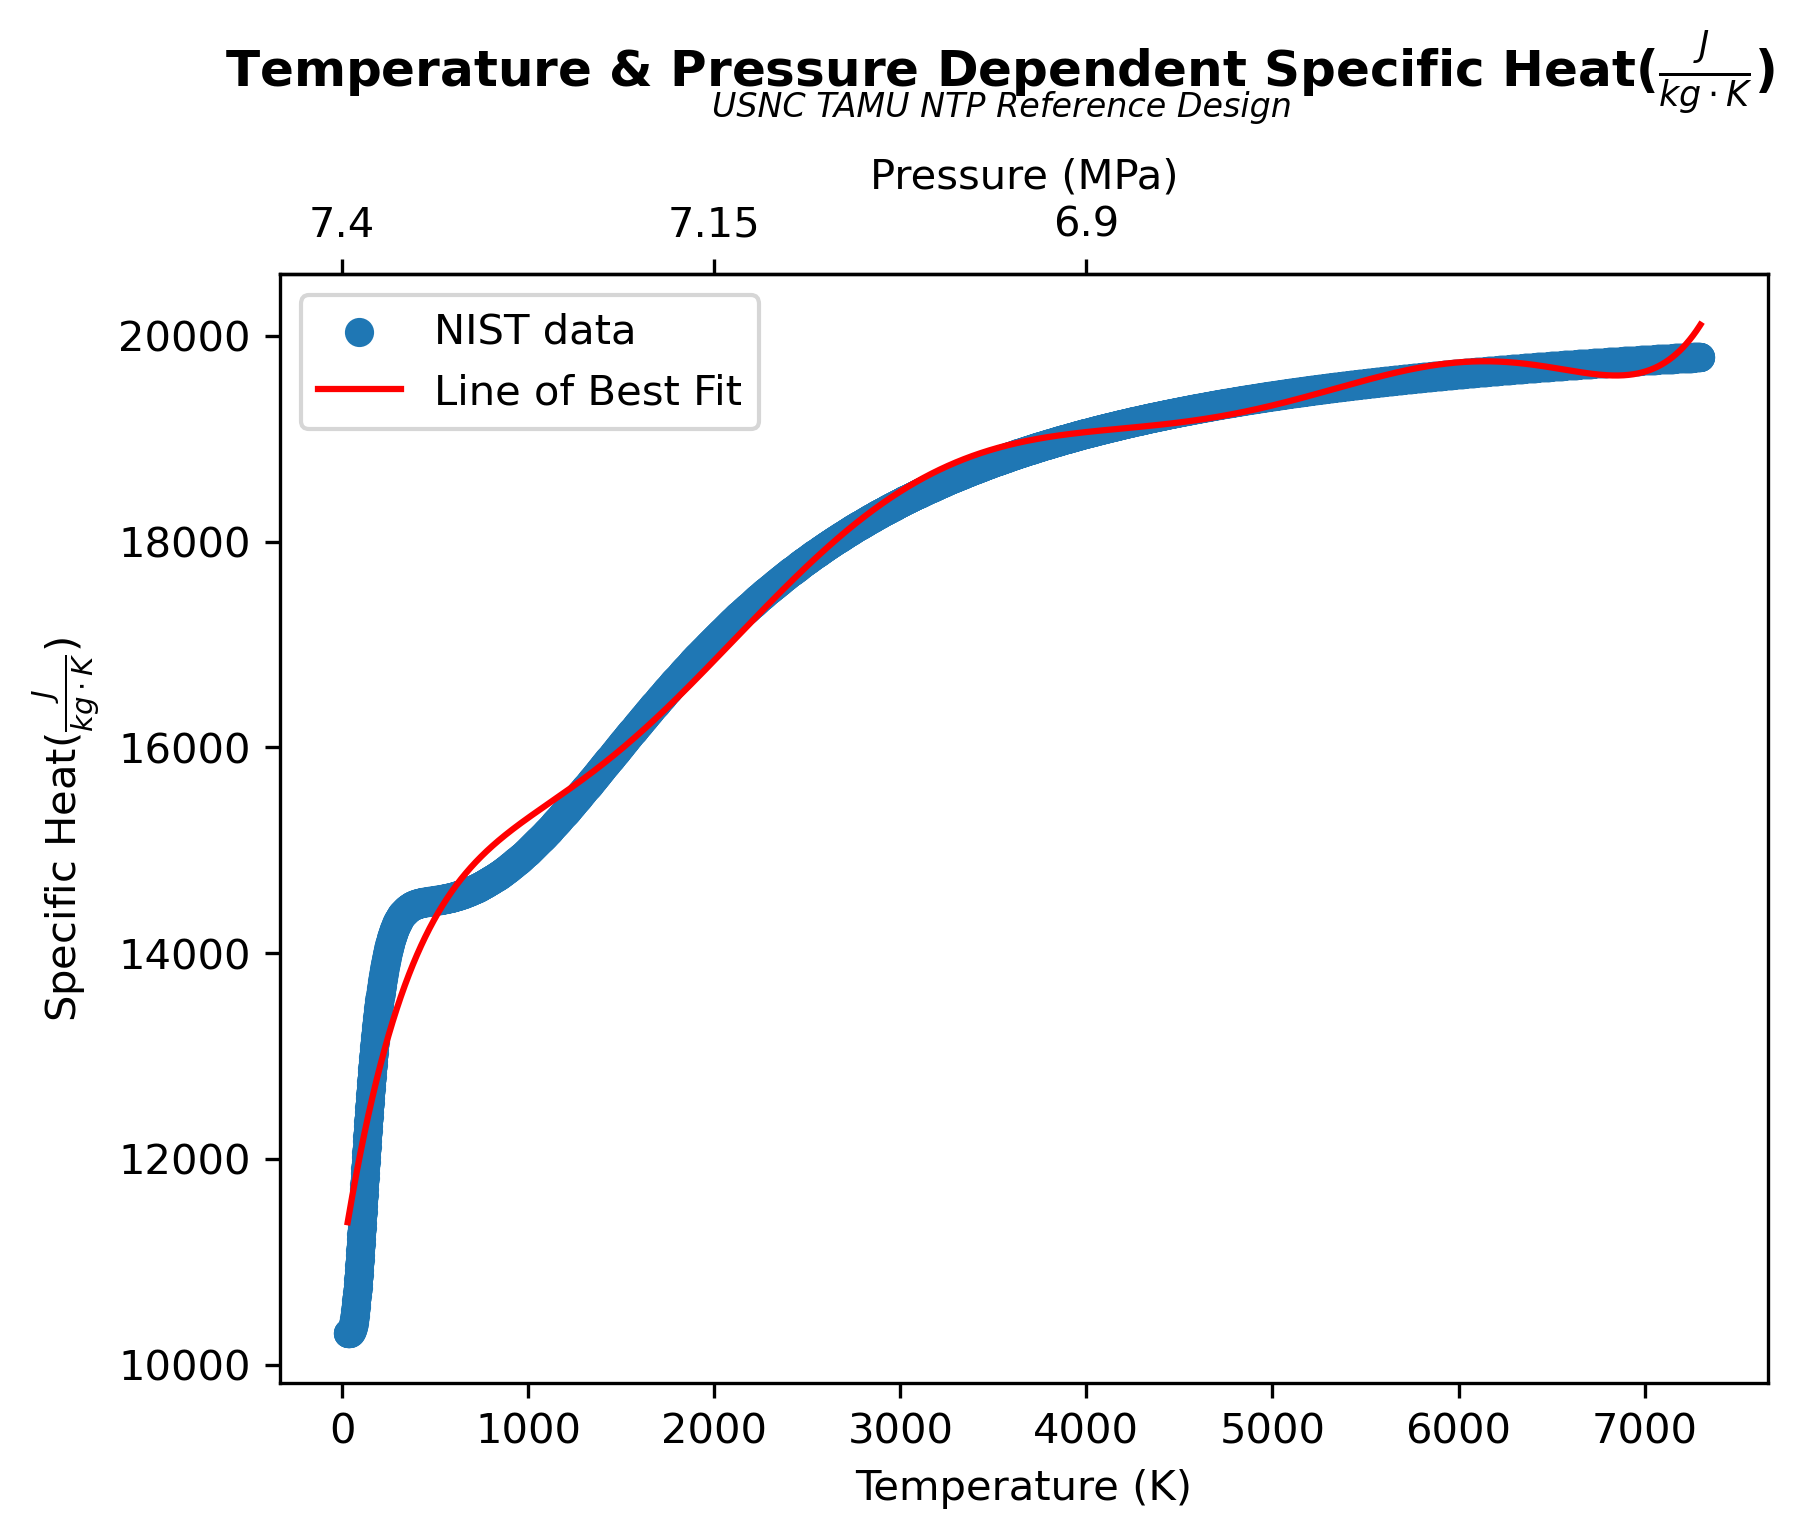

In [164]:

fig, ax = plt.subplots(dpi=300)
fig.suptitle('Temperature & Pressure Dependent Specific Heat'+r'($\frac{J}{kg \cdot K}$)', fontweight='bold', x=0.5, y=1.05)
plt.title(r'USNC TAMU NTP Reference Design', style='italic', fontsize=8, x=0.485, y=1.12)
ax.scatter(temperature,nist_specificHeats,label='NIST data')
ax.plot(temperature,polynomial8(temperature,cpCoefs_nist),label='Line of Best Fit',c='r')
ax.set_xlabel('Temperature (K)')

secax = ax.secondary_xaxis('top') # ******************** this secondary axis stuff is not exact yet
secax.set_xticks([convert_to_primary_x(3.25), convert_to_primary_x(3.275), convert_to_primary_x(3.3)])
secax.set_xticklabels(['7.4', '7.15', '6.9'])
secax.set_xlabel('Pressure (MPa)') # ******************* ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ax.set_ylabel('Specific Heat'+r'($\frac{J}{kg \cdot K}$)')
ax.legend(loc='best')

In [165]:
#plt.figure(3) # plotting viscosity
#plt.scatter(temperature,nist_viscosities,label='NIST data')
#plt.plot(temperature,polynomial8(temperature,muCoefs_nist),label='Line of best fit',c='r')
#plt.title('Viscosity (Pa*s) at 3.15MPa')
#plt.xlabel('Temperature (K)')
#plt.ylabel('Viscosity (Pa*s)')
#plt.ylim(0,300)
#plt.legend(loc='best')

fig, ax = plt.subplots(dpi=300)
fig.suptitle('Temperature & Pressure Dependent Viscosity'+r'($Pa \cdot s$)', fontweight='bold', x=0.5, y=1.05)
plt.title(r'USNC TAMU NTP Reference Design', style='italic', fontsize=8, x=0.485, y=1.12)
ax.scatter(temperature,nist_viscosities,label='NIST data')
ax.plot(temperature,polynomial8(temperature,muCoefs_nist),label='Line of Best Fit',c='r')
ax.plot(temperature,polynomial8(temperature,muCoefs_nist),label='Line of Best Fit',c='r')
ax.set_xlabel('Temperature (K)')

secax = ax.secondary_xaxis('top') # ******************** this secondary axis stuff is not exact yet
secax.set_xticks([convert_to_primary_x(3.25), convert_to_primary_x(3.275), convert_to_primary_x(3.3)])
secax.set_xticklabels(['7.4', '7.15', '6.9'])
secax.set_xlabel('Pressure (MPa)') # ******************* ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ax.set_ylabel('Specific Heat'+r'($Pa \cdot s$)')
plt.xlim(0,7500)
ax.legend(loc='best')

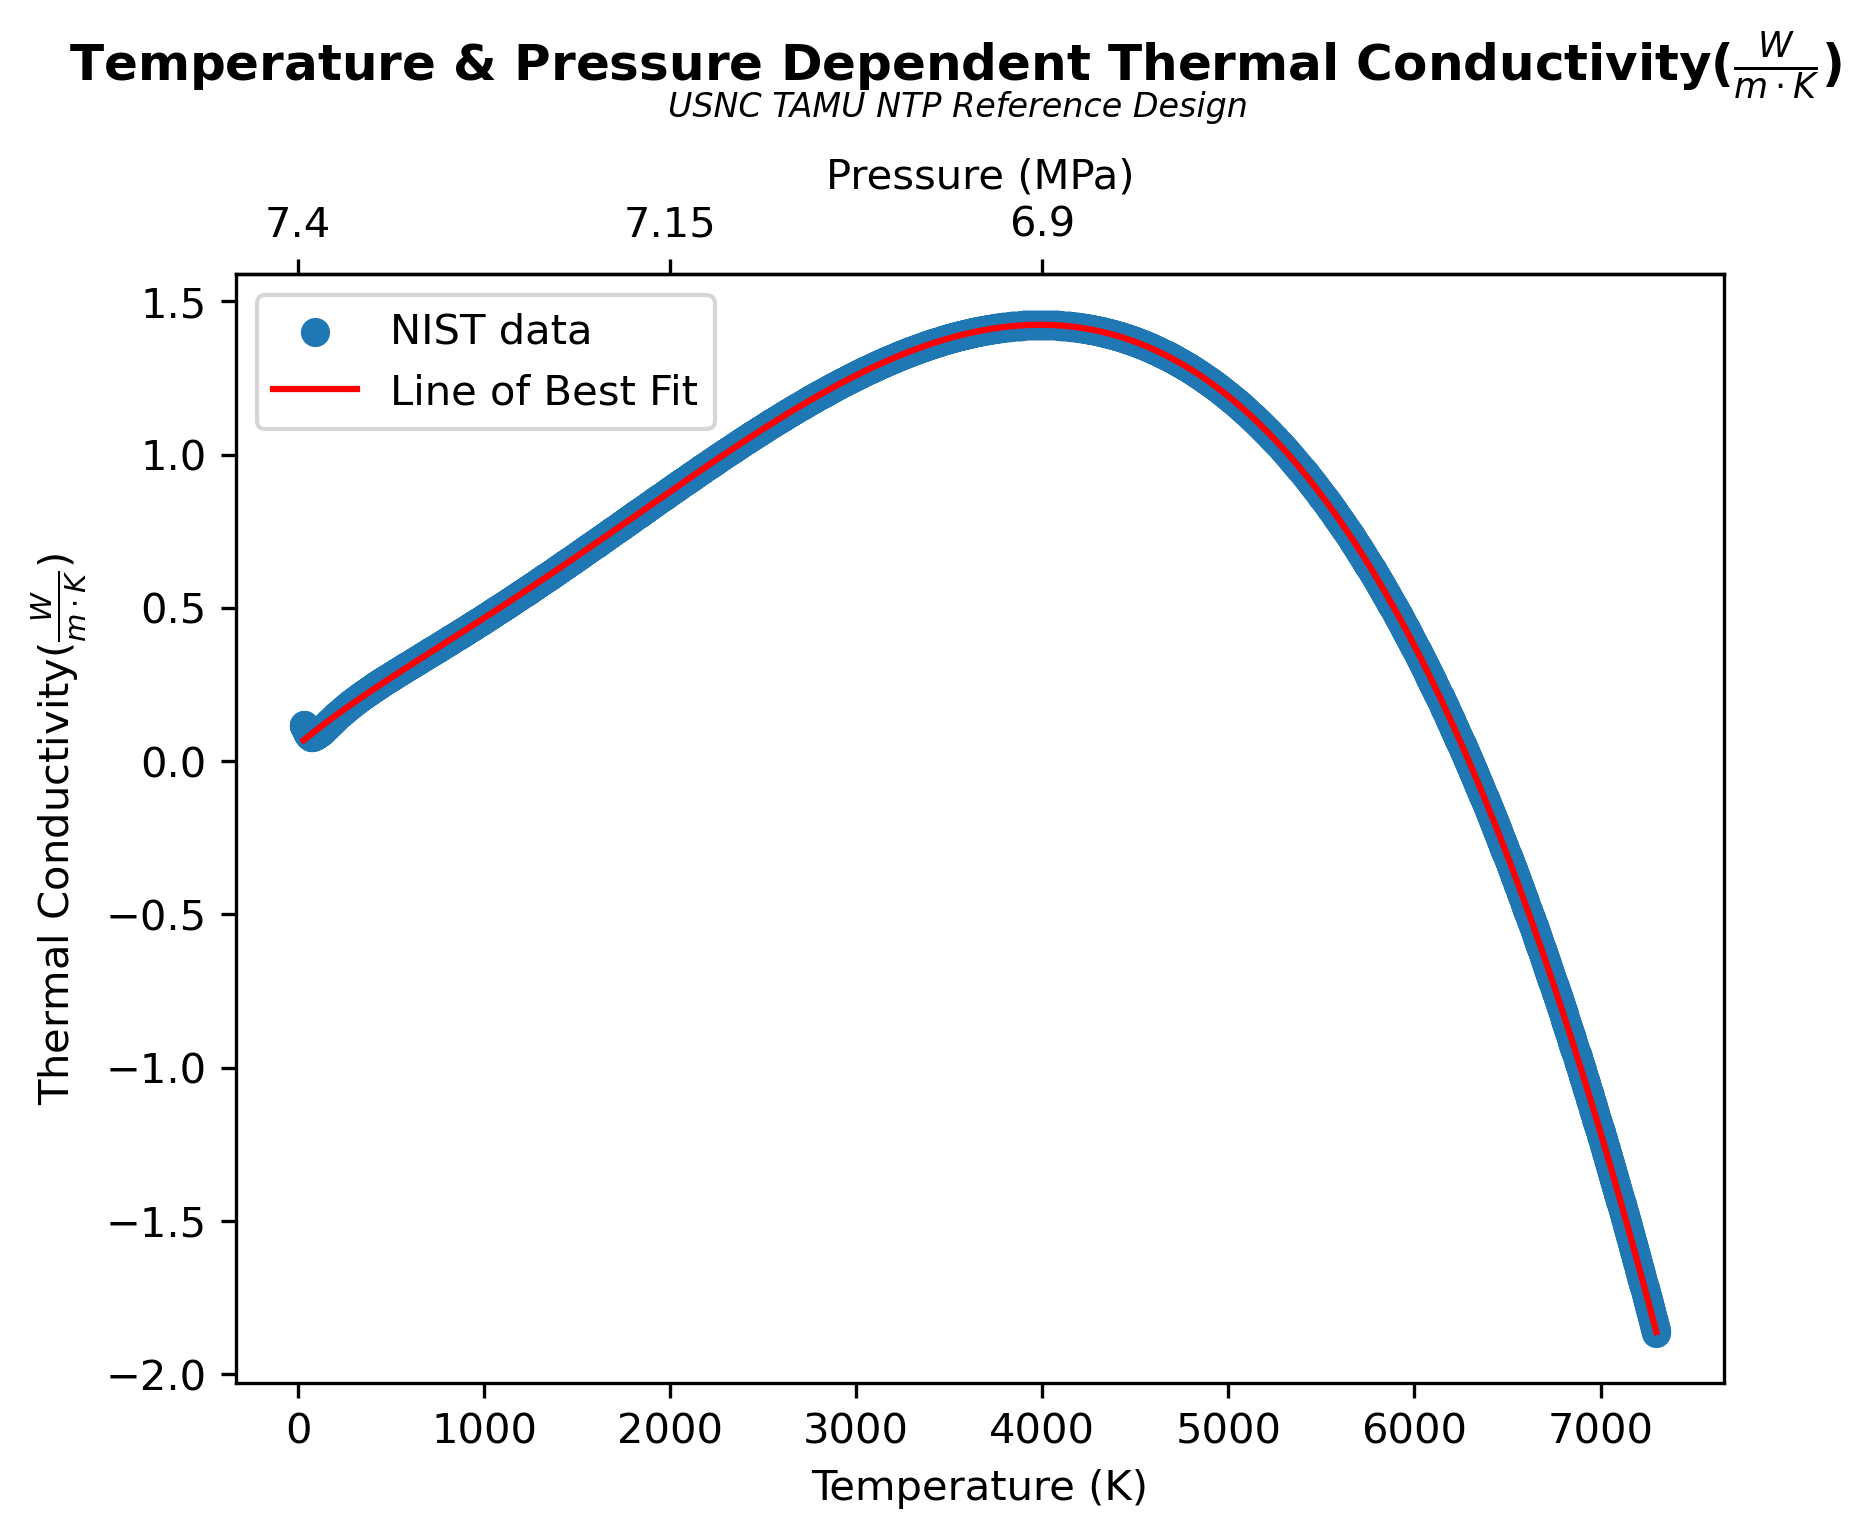

In [166]:
fig, ax = plt.subplots(dpi=300)
fig.suptitle('Temperature & Pressure Dependent Thermal Conductivity'+r'($\frac{W}{m \cdot K}$)', fontweight='bold', x=0.5, y=1.05)
plt.title(r'USNC TAMU NTP Reference Design', style='italic', fontsize=8, x=0.485, y=1.12)
ax.scatter(temperature,nist_conductivities,label='NIST data')
ax.plot(temperature,polynomial8(temperature,kappaCoefs_nist),label='Line of Best Fit',c='r')
ax.set_xlabel('Temperature (K)')

secax = ax.secondary_xaxis('top') # ******************** this secondary axis stuff is not exact yet
halfpointP = np.round((inlet_pressure-outlet_pressure)/2,2)
secax.set_xticks([convert_to_primary_x(3.25), convert_to_primary_x(3.275), convert_to_primary_x(3.3)])
secax.set_xticklabels(['7.4', '7.15', '6.9'])
secax.set_xlabel('Pressure (MPa)') # ******************* ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ax.set_ylabel('Thermal Conductivity'+r'($\frac{W}{m \cdot K}$)')
ax.legend(loc='best')

### Printing coefficients for easy transfer to OpenFOAM

In [167]:
def printCoefs(c,name): # c is coefs
    print(name+'<8> (')
    print('\t'+"{0:.7E}".format(c[0]),"{0:.7E}".format(c[1]),"{0:.7E}".format(c[2]),"{0:.7E}".format(c[3]))
    print('\t'+"{0:.7E}".format(c[4]),"{0:.7E}".format(c[5]),"{0:.7E}".format(c[6]),"{0:.7E}".format(c[7]))
    print(');')

printCoefs(rhoCoefs_nist,'rhoCoeffs')
printCoefs(cpCoefs_nist,'CpCoeffs')
printCoefs(muCoefs_nist,'muCoeffs')
printCoefs(kappaCoefs_nist,'kappaCoeffs')


rhoCoeffs<8> (
	3.0273574E+01 -9.9056511E-02 1.2158912E-04 -7.1964736E-08
	2.2802312E-11 -3.9593026E-15 3.5498133E-19 -1.2843828E-23
);
CpCoeffs<8> (
	1.1053101E+04 1.1474259E+01 -1.3506411E-02 8.7957490E-06
	-2.9994672E-09 5.4671034E-13 -5.0626274E-17 1.8729318E-21
);
muCoeffs<8> (
	3.6989787E-06 1.8792159E-08 -1.4316056E-12 -7.7805420E-16
	4.3589608E-19 -9.3542207E-23 9.3881953E-27 -3.6315601E-31
);
kappaCoeffs<8> (
	5.2899612E-02 5.0883333E-04 -2.0553175E-07 1.5467235E-10
	-5.1750064E-14 8.2067945E-18 -6.8823377E-22 2.3657155E-26
);


### STUFF THAT IS USED AS INPUTS FOR 2DheatCondution.py

In [168]:
rhoCoefs2_nist # linear density relationship hitting inlet + outlet densities exactly

array([ 1.40468123e+00, -1.61065918e-04])

In [169]:
inletDensity, outletDensity, inletCp

(5.698558035197743, 0.22890003338793508, 14313.058231160527)